# PrithviWxC

This notebook will walk through how to construct the model, loading the weights,
building the dataset, and use the model for inference.

In [1]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import torch

We now configuration the backends and torch states, including setting the seeds
for the RNGs.

In [2]:
torch.jit.enable_onednn_fusion(True)
if torch.cuda.is_available():
    print(f"Using device: {torch.cuda.get_device_name()}")
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = True

random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
torch.manual_seed(42)
np.random.seed(42)

We can now set the device to use for inference. The model has ~2.3billion
parameters, so requires some resonable compuational resouces, but it is possible
to run this on a CPU.

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Dataloader
### Variables and times

With the environment ready to go, we now need to set up the task. The core model
expects a fixed set of variables from the MERRA-2 dataset, which are prescribed
below. The variables are comprised of surface variables, surface static
variables, and variables at various vertical levels within the atmosphere. More
details on the MERRA-2 dataset can be found
[here](https://gmao.gsfc.nasa.gov/reanalysis/MERRA-2/). 

The MERRA2 dataset includes data at longtitudes of $-180^\circ$ and
$+180^\circ$, this represents repeated data and so we set a padding variable
to remove this.

The input to the core model are these variables at two times, the time
difference in hours between these samples is passed to the model and is set in
the `input_time` variable.

The task of the model is, given the input data, to predict the fixed set of
variables at a target time. The target time is set relative to input times, ie
if the inputs are 0900 and 1200, giving `input_time=-3`, then a `lead_time=6`
would give a target time of 1800.

In [4]:
surface_vars = [
    "EFLUX",
    "GWETROOT",
    "HFLUX",
    "LAI",
    "LWGAB",
    "LWGEM",
    "LWTUP",
    "PS",
    "QV2M",
    "SLP",
    "SWGNT",
    "SWTNT",
    "T2M",
    "TQI",
    "TQL",
    "TQV",
    "TS",
    "U10M",
    "V10M",
    "Z0M",
]
static_surface_vars = ["FRACI", "FRLAND", "FROCEAN", "PHIS"]
vertical_vars = ["CLOUD", "H", "OMEGA", "PL", "QI", "QL", "QV", "T", "U", "V"]
levels = [
    34.0,
    39.0,
    41.0,
    43.0,
    44.0,
    45.0,
    48.0,
    51.0,
    53.0,
    56.0,
    63.0,
    68.0,
    71.0,
    72.0,
]
padding = {"level": [0, 0], "lat": [0, -1], "lon": [0, 0]}

lead_times = [6]  # This varibale can be change to change the task
input_times = [-6]  # This varibale can be change to change the task

### Data file
MERRA-2 data is available from 1980 to the present day, at 3 hours temporal
resolution. The dataloader we have provided expects the surface data and
vertical data to be saved in seperate files, and when provided with the
directories, will serach for the relavent data that falls within the provided
time range.

In [5]:
time_range = ("2016-02-01T00:00:00", "2016-02-06T23:59:59")

surf_dir = Path("path/to/merra-2")
vert_dir = Path("path/to/merra-2")

### Climatology
The  PrithviWxC model was trained to calculate the output by producing a
perturbation to the climatology at the target time. This mode of operation is
set via the `residual=climate` option. This was chosen as climatology is
typically a strong proir for long-range prediciton. When using the
`residual=climate` option, we have to provide the dataloader with the path of
the climatology data. 

In [6]:
surf_clim_dir = Path("path/to/climatology")
vert_clim_dir = Path("path/to/climatology")

### Postion encoding
Possition data is included in the data passed to the model, as this allows the
attention mechanism to determine data locality rather than explicit or implicit
data connections. The postion data is encoded in the model with two possible
options, `fourier` or `absolute`. As these require different treatmment within
the data loader, it is set here.

In [7]:
positional_encoding = "fourier"

### Dataset init
We can now instantiate the MERRA2 Dataset class provided.

In [8]:
from PrithviWxC.dataloaders.merra2 import Merra2Dataset

dataset = Merra2Dataset(
    time_range=time_range,
    lead_times=lead_times,
    input_times=input_times,
    data_path_surface=surf_dir,
    data_path_vertical=vert_dir,
    climatology_path_surface=surf_clim_dir,
    climatology_path_vertical=vert_clim_dir,
    surface_vars=surface_vars,
    static_surface_vars=static_surface_vars,
    vertical_vars=vertical_vars,
    levels=levels,
    positional_encoding=positional_encoding,
)
assert len(dataset) > 0, "There doesn't seem to be any valid data."

## The model
We are now ready to build the mdoel.
### Scalers
As additional static parameters, the model takes the mean and varience values
of the input varaibles and the varience values of the target difference, ie the
varience between climatology and instaneous variables. We have provided
datafiles containing these and here we load in this data.

In [9]:
from PrithviWxC.dataloaders.merra2 import (
    input_scalers,
    output_scalers,
    static_input_scalers,
)

surf_in_scal_path = Path("path/to/musigma_surface.nc")
vert_in_scal_path = Path("path/to/musigma_vertical.nc")
surf_out_scal_path = Path("path/to/anomaly_variance_surface.nc")
vert_out_scal_path = Path("path/to/anomaly_variance_vertical.nc")

in_mu, in_sig = input_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_in_scal_path,
    vert_in_scal_path,
)

output_sig = output_scalers(
    surface_vars,
    vertical_vars,
    levels,
    surf_out_scal_path,
    vert_out_scal_path,
)

static_mu, static_sig = static_input_scalers(
    surf_in_scal_path,
    static_surface_vars,
)

### Task and additional configs
As we stated above, the pretext task for the PrithviWxC model was predicting the
variable set at the requested lead time by calculating the delta relative to the
climatology at that time. This mode of operation is set via the `residual` flag.
Additional residual options are implemented in hte model, however the core model
weights were not trained with in these modes of operation.

Addtionally, for training and evaluation it is possible to mask tokens in the
model. The masking occuring after tokenisation, prior to the encoder layers.
The model uses multi-axis attention, with data broken down into a hierachy of
local and global patches. Consequently, masking can be configured to mask either
small local patches or larger global patches. This is set via the `masking_mode`
flag. It is possible to set `masking_mode=both`, this doesn't mix the modes, but
rather both modes can be used and swapped between, primarily for training. For
this demonstration we will set the masking ratio to show the reconstrction
abilities of the model.

Finally, we can set up shifting. Primarily in the decioder, this enable
alternate shifting of the attention windows, similar to the SWIN model. This
option requires the number of decoder blocks to be even, and cannot be used in
the encoder when masking is also used.

In [10]:
residual = "climate"
masking_mode = "local"
decoder_shifting = True
masking_ratio = 0.99

### Model init
We now have all the peices to build the model. If you are using the pretrained
weights, then a number of the model hyperparameters are predetermined and
included below. With this configuration, the model will have approximately
2.3billion parameters. Therefore, if you want to train the fully unfrozen model,
you will likely need to use a model distribution approach, such as fully shared
data parallelism (FSDP). To further reduce the memory usage of the model,
when gradients are required, there two varaiables --- `checkpoint_encoder` and
`checkpoint_decoder` --- which enable activation checkpointing of desired
transformer layers.

In [11]:
from PrithviWxC.model import PrithviWxC

model = PrithviWxC(
    in_channels=160,
    input_size_time=2,
    in_channels_static=8,
    input_scalers_mu=in_mu,
    input_scalers_sigma=in_sig,
    input_scalers_epsilon=0.0,
    static_input_scalers_mu=static_mu,
    static_input_scalers_sigma=static_sig,
    static_input_scalers_epsilon=0.0,
    output_scalers=output_sig**0.5,
    n_lats_px=360,
    n_lons_px=576,
    patch_size_px=[2, 2],
    mask_unit_size_px=[30, 32],
    mask_ratio_inputs=masking_ratio,
    embed_dim=2560,
    n_blocks_encoder=12,
    n_blocks_decoder=2,
    mlp_multiplier=4,
    n_heads=16,
    dropout=0.0,
    drop_path=0.0,
    parameter_dropout=0.0,
    residual=residual,
    masking_mode=masking_mode,
    decoder_shifting=decoder_shifting,
    positional_encoding=positional_encoding,
    checkpoint_encoder=[],
    checkpoint_decoder=[],
)

### Load weights
We have provided unshared pretrained weights for the model, which can now be
loaded and model can then be transfered to the requested device.

In [12]:
weights_path = Path("path/to/pretrained/wieghts.pt")

state_dict = torch.load(weights_path, weights_only=False)
if "model_state" in state_dict:
    state_dict = state_dict["model_state"]
model.load_state_dict(state_dict, strict=True)

if (hasattr(model, "device") and model.device != device) or not hasattr(
    model, "device"
):
    model = model.to(device)

## Inference
We are now ready to performace inference on the model. The data returned from
the dataset class requires some additional preprocessing, so after polling the
dataset we run the data through the `preproc` function. This data can then be
transfered to the device.

To retreive the masking, we can save the torch RNG state and use it to recover
the masking later. Finally, we can run the model in evaluation mode and without
generating the gradient graph.

In [13]:
from PrithviWxC.dataloaders.merra2 import preproc

data = next(iter(dataset))
batch = preproc([data], padding)

for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)

rng_state_1 = torch.get_rng_state()
with torch.no_grad():
    model.eval()
    out = model(batch)

## Plotting

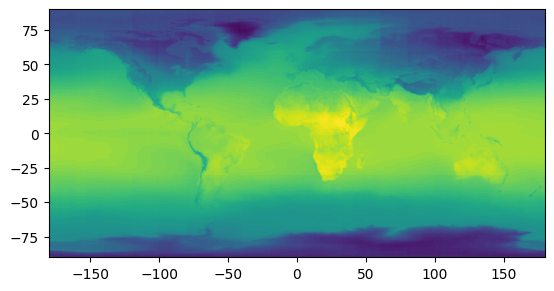

In [14]:
t2m = out[0, 12].cpu().numpy()

lat = np.linspace(-90, 90, out.shape[-2])
lon = np.linspace(-180, 180, out.shape[-1])
X, Y = np.meshgrid(lon, lat)

plt.contourf(X, Y, t2m, 100)
plt.gca().set_aspect("equal")
plt.show()